# Face classifier - Baseline Model

## Set up

In [21]:
# 3rd party imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, roc_curve, roc_auc_score

# Local imports
from facecls import fcaux

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)

## Load data

In [3]:
data = pd.read_csv("data/age_gender.csv")

## Baseline model: Multilayer perceptron classifier

In [4]:
full_img_vec_list = np.array([fcaux.pxlstring2pxlvec(data, i) for i in range(data.shape[0])])

In [25]:
target = "gender"
X_train, X_test, y_train, y_test = train_test_split(full_img_vec_list, 
                                                    data[target],
                                                    test_size = 0.2,
                                                    stratify = data[target],
                                                    shuffle = True,
                                                    random_state = seed,
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                    y_train,
                                                    test_size = 0.1,
                                                    stratify = y_train,
                                                    shuffle = True,
                                                    random_state = seed,
                                                    )

In [26]:
base_model = MLPClassifier(hidden_layer_sizes = (128,),
                           activation='relu', 
                           solver='adam', 
                           tol = 0.01,
                           batch_size = 16,
                           learning_rate='adaptive',
                           verbose = True,
                           shuffle = True,
                           early_stopping = True,
                           n_iter_no_change = 5,
                           validation_fraction=0.1,
                           random_state = seed)

In [14]:
base_model.fit(X_train, y_train)

Iteration 1, loss = 4.57752668
Validation score: 0.655245
Iteration 2, loss = 1.19597024
Validation score: 0.688455
Iteration 3, loss = 0.43504701
Validation score: 0.818661
Iteration 4, loss = 0.41423747
Validation score: 0.819715
Iteration 5, loss = 0.41744300
Validation score: 0.692145
Iteration 6, loss = 0.40727860
Validation score: 0.820242
Iteration 7, loss = 0.41701152
Validation score: 0.805482
Iteration 8, loss = 0.51204053
Validation score: 0.797048
Iteration 9, loss = 0.46617550
Validation score: 0.832894
Iteration 10, loss = 0.44021350
Validation score: 0.809172
Iteration 11, loss = 0.42391847
Validation score: 0.827095
Iteration 12, loss = 0.43146776
Validation score: 0.822351
Iteration 13, loss = 0.42276686
Validation score: 0.817080
Iteration 14, loss = 0.41298636
Validation score: 0.837638
Iteration 15, loss = 0.40942652
Validation score: 0.833948
Validation score did not improve more than tol=0.010000 for 5 consecutive epochs. Stopping.


MLPClassifier(batch_size=16, early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate='adaptive', n_iter_no_change=5, random_state=42,
              tol=0.01, verbose=True)

In [63]:
mlp = MLPClassifier(hidden_layer_sizes = (1024,),
                           activation='relu', 
                           solver='adam', 
                           tol = 0.01,
                           batch_size = 32,
                           learning_rate='adaptive',
                           verbose = True,
                           shuffle = True,
                           max_iter=1,
                           warm_start=True,
                           random_state = seed)

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

n_epochs = 20
for epoch in range(n_epochs):
    # Fit the model for one epoch
    mlp.partial_fit(X_train, y_train, classes=np.unique(data[target].values))
    
    # Calculate the training loss
    train_prob = mlp.predict_proba(X_train)
    train_loss = log_loss(y_train, train_prob)
    training_losses.append(train_loss)
    
    # Calculate the validation loss
    val_prob = mlp.predict_proba(X_val)
    val_loss = log_loss(y_val, val_prob)
    validation_losses.append(val_loss)
    
    # Calculate the training accuracy
    train_pred = mlp.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    training_accuracies.append(train_accuracy)

    # Calculate the validation accuracy
    val_pred = mlp.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)
    validation_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch + 1}/{n_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f} - Training Accuracy: {train_accuracy:.4f}')


Iteration 1, loss = 5.94314230
Epoch 1/20 - Training Loss: 8.0426 - Validation Loss: 7.9119 - Training Accuracy: 0.5993
Iteration 1, loss = 2.39998403
Epoch 2/20 - Training Loss: 2.1020 - Validation Loss: 1.9320 - Training Accuracy: 0.7233
Iteration 1, loss = 1.39417851
Epoch 3/20 - Training Loss: 1.7487 - Validation Loss: 1.6101 - Training Accuracy: 0.7005
Iteration 1, loss = 0.83004637
Epoch 4/20 - Training Loss: 0.4883 - Validation Loss: 0.4819 - Training Accuracy: 0.8342
Iteration 1, loss = 0.54858982
Epoch 5/20 - Training Loss: 0.3547 - Validation Loss: 0.3397 - Training Accuracy: 0.8473
Iteration 1, loss = 0.42254279
Epoch 6/20 - Training Loss: 0.3848 - Validation Loss: 0.3658 - Training Accuracy: 0.8243
Iteration 1, loss = 0.39823482
Epoch 7/20 - Training Loss: 0.3687 - Validation Loss: 0.3528 - Training Accuracy: 0.8301
Iteration 1, loss = 0.38662232
Epoch 8/20 - Training Loss: 0.3649 - Validation Loss: 0.3491 - Training Accuracy: 0.8323
Iteration 1, loss = 0.39181476
Epoch 9/2

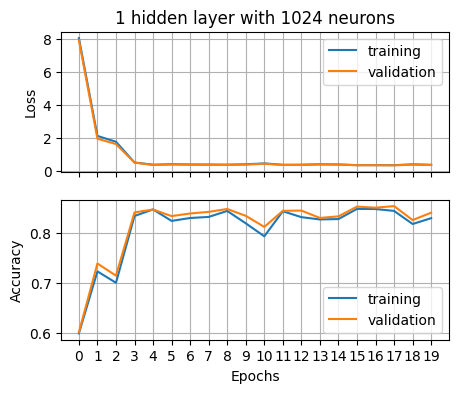

In [64]:
fig, axs = plt.subplots(2,1, figsize=(5,4), sharex=True)
ax = axs[0]
ax.plot(training_losses, label="training")
ax.plot(validation_losses, label="validation")
ax.grid(True)
ax.set_xticks(range(20))
ax.set_ylabel("Loss")
ax.set_title("1 hidden layer with 1024 neurons")
ax.legend(loc="best")

ax = axs[1]
ax.plot(training_accuracies, label="training")
ax.plot(validation_accuracies, label="validation")
ax.grid(True)
ax.set_xticks(range(20))
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend(loc="best")

plt.savefig("results/loss_curve_1x1024_mlp.png")
plt.show()

In [ ]:
parameters = {'hidden_layer_sizes':[(32), (64), (128), (256), (512),
                                    (32, 32), (64, 64), (128, 128), (256, 128), (512, 256),
                                    
                                    ],
              'alpha': [0.001, 0.01, 0.1], 
              'max_iter': [10, 50, 100], 
              'learning_rate_init':[0.001, 0.01, 0.1],
              'batch_size': [16, 32]}

base_model = MLPClassifier(activation='relu', 
                           solver='adam', 
                           tol = 0.01,
                           learning_rate='adaptive',
                           verbose = True,
                           shuffle = True,
                           n_iter_no_change = 5,
                           random_state = seed)

cv_model = RandomizedSearchCV(estimator=base_model, 
                              param_distributions=parameters,
                              cv = 3,
                              random_state = seed,
                              verbose = True,
                              n_iter = 5)

cv_model.fit(X_train, y_train)

In [ ]:
plt.plot(cv_model.best_estimator_.loss_curve_)

In [ ]:
cv_model.best_score_

In [ ]:
base_best_params = pd.DataFrame({k: str(v) for k,v in cv_model.best_params_.items()}, index=[0])
base_best_params.to_csv("../results/base_model__best_params.csv", index=False)

In [ ]:
y_pred = cv_model.best_estimator_.predict(X_test)

In [ ]:
#accuracy_score(y_test, y_pred)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

In [ ]:
# Exploiting universal approximation theorem (UAT) for wide, shallow networks
wide_shallow = [(2**n,) for n in range(4,15)]

# Exploiting universal approximation theorem (UAT) for narrow, deep networks
narrow_deep  = [tuple(i*[64]) for i in range(2,5)]

parameters = {'hidden_layer_sizes': wide_shallow + narrow_deep,
              'alpha': [0.001, 0.01, 0.1], 
              'max_iter': [10, 50, 100], 
              'learning_rate_init':[0.001, 0.01, 0.1],
              'batch_size': [16, 32]}

base_model = MLPClassifier(activation='relu', 
                           solver='adam', 
                           tol = 0.01,
                           learning_rate='adaptive',
                           verbose = True,
                           shuffle = True,
                           n_iter_no_change = 5,
                           random_state = seed)

cv_model2 = RandomizedSearchCV(estimator=base_model, 
                              param_distributions=parameters,
                              cv = 3,
                              random_state = seed,
                              verbose = True,
                              n_iter = 10)

cv_model2.fit(X_train, y_train)

In [ ]:
base_best_params2 = pd.DataFrame({k: str(v) for k,v in cv_model2.best_params_.items()}, index=[0])
base_best_params2["score"] = cv_model2.best_score_
base_best_params2.to_csv("../results/base_model2__best_params.csv", index=False)

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(1,len(cv_model2.best_estimator_.loss_curve_)+1), cv_model2.best_estimator_.loss_curve_)
ax.set_title("Loss curve")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss value")
plt.show()

In [ ]:
y_pred = cv_model2.best_estimator_.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
fpr, tpr, thr = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], ls=":", c="k")